In [230]:
import math
import random

import numpy as np
import torch
import torch.nn.functional as F
from kan import KAN as PyKAN
from matplotlib import pyplot as plt
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate the dataset

In [256]:
G = 1  #6.67430e-11


def generate_dataset(num_samples=1000, noise_std=1e-12):
    m1, m2 = np.random.uniform(0.5, 1, num_samples), np.random.uniform(0.5, 1, num_samples)
    # dx, dy, dz = (np.random.uniform(-1, 1, num_samples),
    #               np.random.uniform(-1, 1, num_samples),
    #               np.random.uniform(-1, 1, num_samples))
    d = np.random.uniform(0.5, 1, num_samples)
    # r = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    r = d
    F = (m1 * m2) / (r ** 2)

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, num_samples)
    return np.column_stack((m1, m2, d)), F  #+ noise


train_set = generate_dataset(num_samples=10000, noise_std=1e-12)
test_set = generate_dataset(num_samples=5000, noise_std=1e-12)
dataset = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}

## Train the KAN

In [32]:
model = PyKAN(width=[3, 3, 3, 3, 1, 1], grid=3, k=3, grid_range=[0.5, 1])
model.fit(dataset, opt="LBFGS", steps=40, lamb=0.01, lamb_entropy=100)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.00e-01 | test_loss: 9.91e+00 | reg: 1.83e+02 | : 100%|█| 40/40 [00:29<00:00,  1.37it

saving model version 0.1


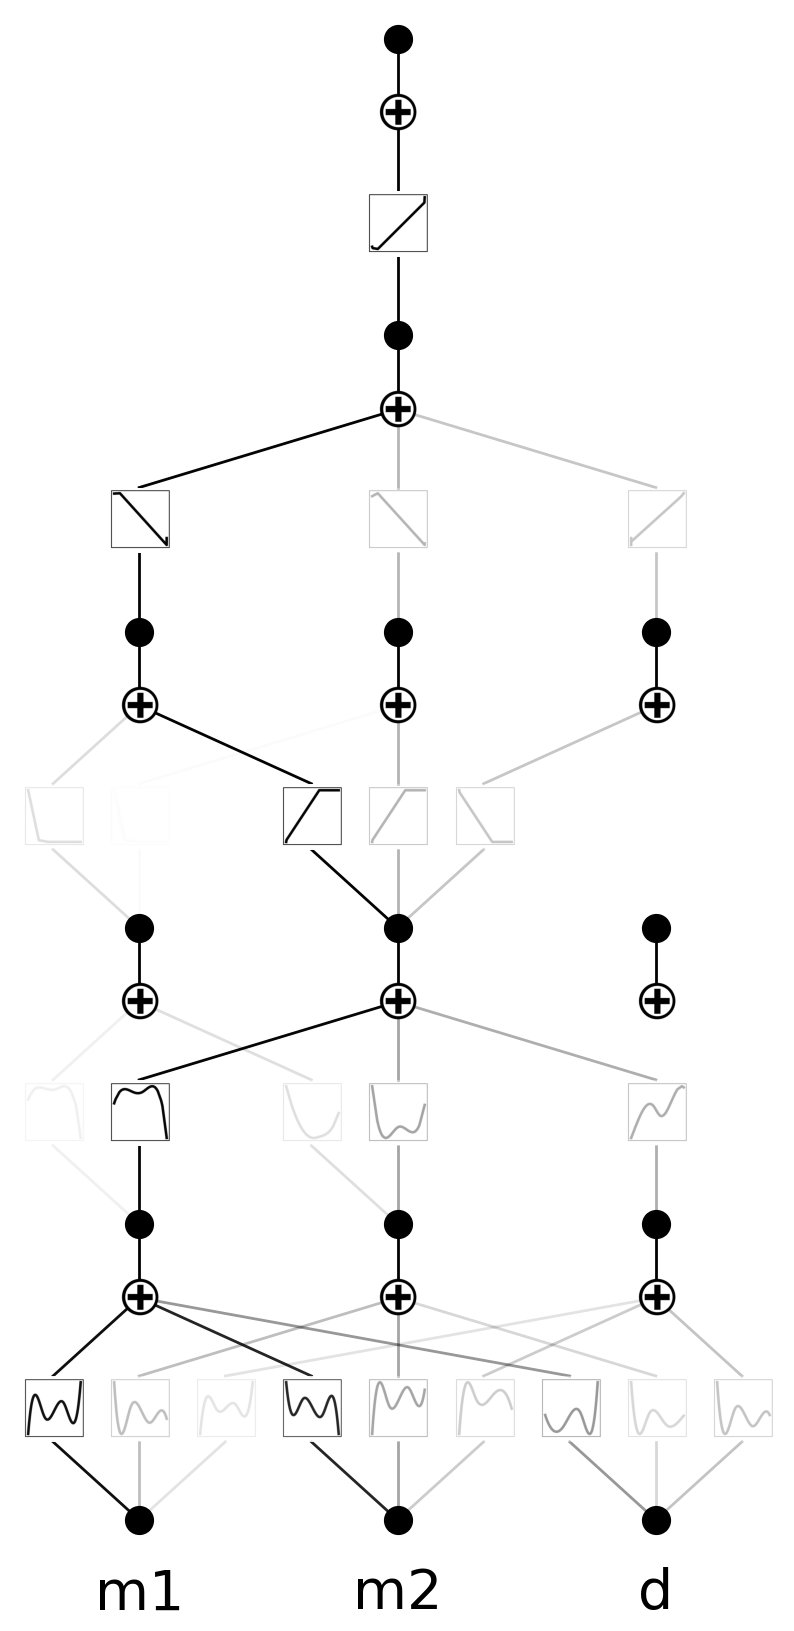

In [33]:
model.plot(in_vars=['m1', 'm2', 'd'], scale=1)

## EfficientKAN

In [224]:
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200, shape=None):
        super(Efficient_KAN, self).__init__()
        if shape is None:
            shape = [1, 1]
        self.layers = shape
        self.model = EffKAN(self.layers,
                            grid_size=grid_size,
                            scale_base=0,
                            sp_trainable=False,
                            sb_trainable=False,
                            ).to(device)
        self.double()

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        return x

In [220]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y.double())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()

In [221]:
def test(model, inputs, labels, batch_size=100):
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                output = model(x).cpu()
                output = output.squeeze()
                losses.append(criterion(output, y.double()))
    return (sum(losses) / len(losses)).item()

In [266]:
model2 = Efficient_KAN(grid_size=5, shape=[3, 3, 3, 1])

In [276]:
train(model2, optim.Adam(model2.parameters(), lr=0.00525), dataset["train_input"], dataset["train_label"], epochs=100,
      batch_size=1000)

100%|██████████| 10/10 [00:00<00:00, 80.31it/s, loss=5.6e-7, lr=3.53e-5]


In [273]:
test(model2, dataset["test_input"], dataset["test_label"])

100%|██████████| 50/50 [00:00<00:00, 605.97it/s]


9.675165391814978e-07

In [264]:
def plot_spline(model: EffKAN, x_range, scale=1, resolution=50):
    base_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

    def random_color():
        return random.random(), random.random(), random.random()

    colors = [base_colors[x] if x < len(base_colors) else random_color()
              for x in range(max(map(lambda l: l.in_features, model.layers)))]
    for layer in reversed(model.layers):
        fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                                 figsize=(2 * scale * layer.in_features * layer.out_features, 2 * scale))
        for i in range(layer.in_features):
            for j in range(layer.out_features):
                x_vals = torch.linspace(x_range[0], x_range[1], resolution)
                # expanded_x_vals = torch.cat((x_vals, torch.zeros(resolution * (layer.in_features - 1))))
                # y_vals = F.linear(
                #     layer.b_splines(expanded_x_vals.view(-1, layer.in_features)),
                #     layer.scaled_spline_weight.view(layer.in_features * layer.out_features, -1),
                # ).view(-1).detach()[:resolution]
                # y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

                # B-Splines
                grid = layer.grid[j, :].unsqueeze(0)  # The knots
                x = x_vals.unsqueeze(-1).unsqueeze(-1)
                bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)  # Determine the interval for each point
                for k in range(1, layer.spline_order + 1):
                    bases = (
                                    (x - grid[:, : -(k + 1)])
                                    / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                    * bases[:, :, :-1]
                            ) + (
                                    (grid[:, k + 1:] - x)
                                    / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                    * bases[:, :, 1:]
                            )

                y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i]).detach()
                y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

                alpha = math.tanh(abs(3 * layer.spline_scaler.view(layer.out_features, -1)[j, i].item()))
                if type(axes) is np.ndarray:
                    axes[i * layer.out_features + j].plot(x_vals, y_vals.detach(), alpha=alpha, color=colors[i])
                    axes[i * layer.out_features + j].grid(True)
                else:
                    axes.plot(x_vals, y_vals.detach(), alpha=alpha, color=colors[i])
                    axes.grid(True)

    # plt.tight_layout()
    plt.show()

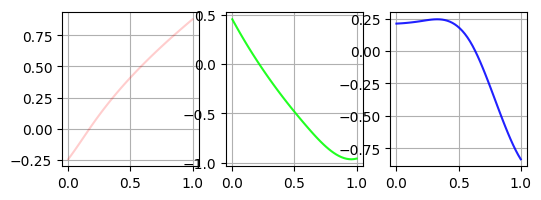

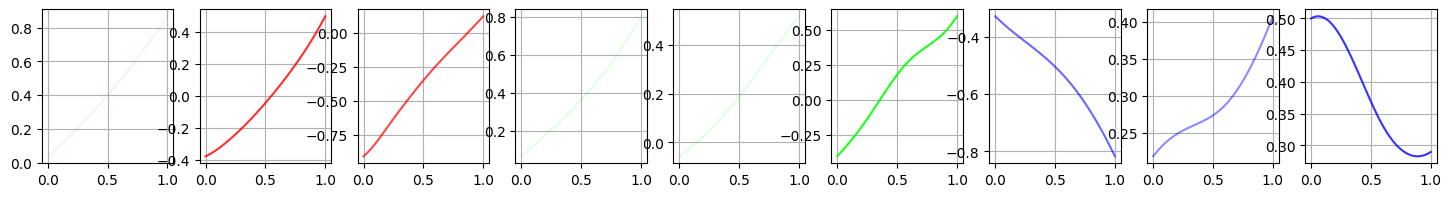

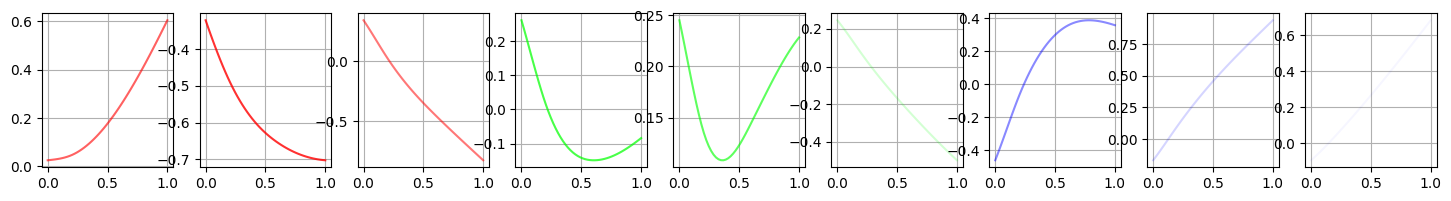

In [277]:
plot_spline(model2.model, [0, 1])